## Import libraries

In [55]:
%conda upgrade matplotlib
%conda install nbconvert
%conda install traitlets

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import mlflow
import datetime

np.random.seed(1)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


## Configure Client Environment

In [56]:
os.environ['AWS_ACCESS_KEY_ID']='i9GMOGOmV3yZ3UAXPtXd'
os.environ['AWS_SECRET_ACCESS_KEY']='cN7yMaosU9hi8VcQyx60BmkrOnl3bDQXsx2AOnYP'
os.environ['AWS_DEFAULT_REGION']='us-west-2'
os.environ['MLFLOW_S3_ENDPOINT_URL']='https://minio.tanzudatatap.ml'
os.environ['MLFLOW_S3_IGNORE_TLS']='true'
    

mlflow.set_tracking_uri('http://mlflow.tanzudatatap.ml')

# Set up experiment
mlflow.set_experiment('sentiment-analysis-logistic-regression')
if mlflow.active_run() is not None:
    mlflow.end_run()
mlflow.start_run()

# Enable autologging
mlflow.sklearn.autolog()

from mlflow.tracking import MlflowClient
client = MlflowClient()

# Set artifact path
from datetime import datetime
artifact_path = datetime.now().strftime("%Y%m%d%H%M%S")
print(artifact_path)

2022/04/14 20:14:46 ERROR mlflow.utils.rest_utils: API request to http://mlflow.tanzudatatap.ml/api/2.0/mlflow/runs/update failed with code 500 != 200, retrying up to 2 more times. API response body: <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>

2022/04/14 20:14:49 ERROR mlflow.utils.rest_utils: API request to http://mlflow.tanzudatatap.ml/api/2.0/mlflow/runs/update failed with code 500 != 200, retrying up to 1 more times. API response body: <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>



20220414201453


## Data Collection: Ingest Data

In [57]:
csv = pd.read_csv('data/Tweets.csv')
csv.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Feature Extraction: Extract Relevant Columns

In [58]:
df = csv[['airline_sentiment','text']].copy()
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


## Visualization: Check for class imbalance

<AxesSubplot:>

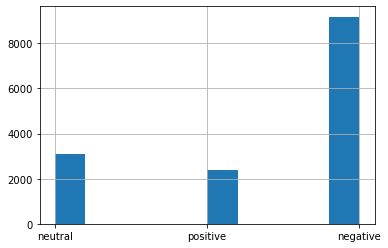

In [59]:
df['airline_sentiment'].hist()

## Data Preparation: Apply ordinal encoding

In [60]:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)
df.head()

,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


## Model Selection: Train-Test-Validation Split

In [61]:
df_train, df_test = train_test_split(df)

## Vectorization: Apply tf-idf transformation

In [62]:
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(df_train['text'])
X_train
X_test = vectorizer.transform(df_test['text'])
X_test
Y_train = df_train['target']
Y_test = df_test['target']

## Training: Generate Logistic Regression model

In [63]:
model = LogisticRegression(max_iter=500) # TODO: try different values of C, penalty
model.fit(X_train, Y_train)

# Tag the active run
run = mlflow.active_run()
client.set_tag(run.info.run_id, "region", "US East")

2022/04/14 20:14:57 WARNING mlflow.sklearn: Failed to infer model signature: Expected one of (pandas.DataFrame, numpy array, dictionary of (name -> numpy.ndarray), pyspark.sql.DataFrame) but got '<class 'scipy.sparse.csr.csr_matrix'>'


## Model Evaluation: Generate Metrics

In [64]:
train_acc = model.score(X_train, Y_train)
test_acc = model.score(X_test, Y_test)
train_roc_auc = roc_auc_score(Y_train, model.predict_proba(X_train),multi_class='ovo')
test_roc_auc = roc_auc_score(Y_test, model.predict_proba(X_test),multi_class='ovo')
print(f'Training accuracy: {train_acc}\nTest accuracy: {test_acc}\nTraining AUC: {train_roc_auc}\nTest AUC: {test_roc_auc}')

Training accuracy: 0.8548269581056467
Test accuracy: 0.7991803278688525
Training AUC: 0.9430937419928069
Test AUC: 0.8954013846968852


## Model Evaluation: Generate Confusion Matrix

In [65]:
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)
train_cm = confusion_matrix(Y_train,train_prediction,normalize='true')
train_cm
test_cm = confusion_matrix(Y_test,test_prediction,normalize='true')
test_cm

array([[0.93059799, 0.01658664, 0.05281536],
       [0.24537815, 0.63865546, 0.11596639],
       [0.40826873, 0.05813953, 0.53359173]])

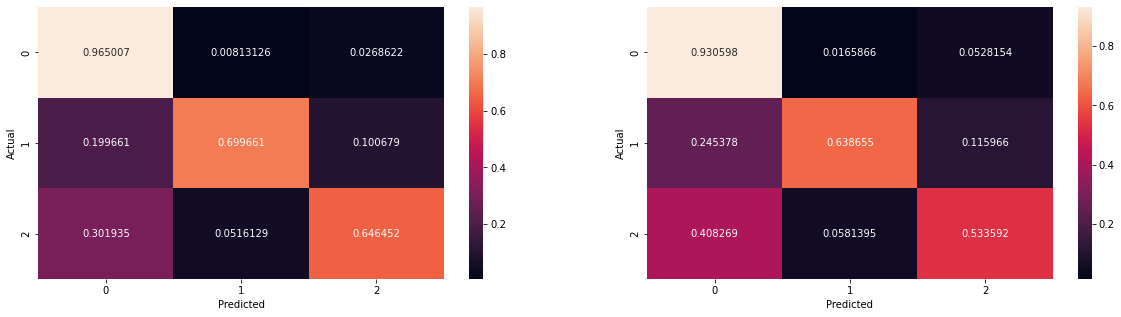

In [66]:
def plot_cm(*cms):
    classes = ['negative','positive','neutral']
    fig, axs = plt.subplots(1, len(cms), sharex=True, figsize=(20,5)) 
    for index, cm in enumerate(cms):
        cm_df = pd.DataFrame(cm, index=classes, columns=classes)
        sns.heatmap(cm, ax=axs[index], annot=True, fmt='g')
        axs[index].set_xlabel('Predicted')
        axs[index].set_ylabel('Actual')
    
plot_cm(train_cm,test_cm)

## Artifact Storing: Save Plot

In [67]:
plt.savefig('confusion-matrix.png')
mlflow.log_artifact('confusion-matrix.png')

<Figure size 432x288 with 0 Axes>

## Model Storing: Save Model, Vectorizer

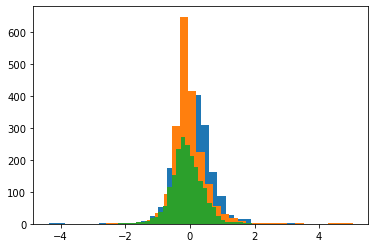

In [68]:
model.coef_
for index, a in enumerate(model.coef_):
    plt.hist(model.coef_[index], bins=30)
    
mlflow.sklearn.log_model(model, "sentiment-analysis-logreg-model")
mlflow.sklearn.log_model(vectorizer, "sentiment-analysis-vectorizer")

## Data Enrichment: Generate word-to-index mapping

In [69]:
word_index_map = vectorizer.vocabulary_
word_index_map
most_positive_threshold = np.percentile(model.coef_[1],99)
most_negative_threshold = np.percentile(model.coef_[0],99)

print('Most positive words:')
for word, index in word_index_map.items():
    if model.coef_[1][index]>most_positive_threshold:
        print(word, model.coef_[1][index])
        
print('\nMost negative words:')
for word, index in word_index_map.items():
    if model.coef_[0][index]>most_negative_threshold:
        print(word, model.coef_[0][index])

Most positive words:
nice 1.6482231847835234
thank 4.690761774214919
airline 1.65123377444839
thanks 5.043204626628911
great 4.337274921798195
best 2.9136999886622026
thx 2.530012613977005
good 2.3029960645647884
love 3.3594244716513484
appreciate 2.420992628608694
helpful 1.7279144226781429
awesome 3.3841886318003107
cool 1.7817315331398285
rock 1.722158514579637
kudos 2.1697709487910783
excellent 1.75776229613415
amazing 3.2635938663224877
worries 2.0509616584939456
wonderful 1.819399200714711
thnx 1.6446715731933963

Most negative words:
hours 2.988798915303761
not 3.2502235535191994
delayed 2.8551426972855363
stuck 2.2822575453449576
your 1.9013619619879794
hour 2.077216195228979
again 1.894400674030503
cancelled 2.6534875200624954
delay 2.4504724620460623
nothing 2.1774451997476865
call 1.87822207682126
no 3.4633098316973467
bags 1.8662337274982979
worst 3.225045533053224
hold 2.545408094288282
why 2.384927174949061
luggage 2.283305397732512
doesn 2.1250703661405757
lost 2.1146120

## Serve the model

In [70]:
# mlflow models serve -m my_model

## Prediction: Generate scoring on sample tweets

In [71]:
def predict(text):
    #logged_vectorizer = mlflow.sklearn.load_model(model, "sentiment-analysis-logreg-model")
    #logged_model = mlflow.sklearn.load_model(vectorizer, "sentiment-analysis-vectorizer")
    sample = pd.Series(text)
    transformed_sample = vectorizer.transform(sample)
    classes = ['negative','positive','neutral']
    return classes[model.predict(transformed_sample)[0]]

print(predict('I think Virgin Airlines is nice!'))
print(predict('Southwest sucks'))

positive
negative
